In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading Dataset

In [2]:
url = 'https://drive.google.com/uc?id=1coV2MwlIKhx0GlpkwnrUjE-XjhS2KW8A'

In [3]:
df = pd.read_csv('Fraud.csv')

In [4]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


## Data Cleaning

### Missing Values

In [5]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Detecting Outliers

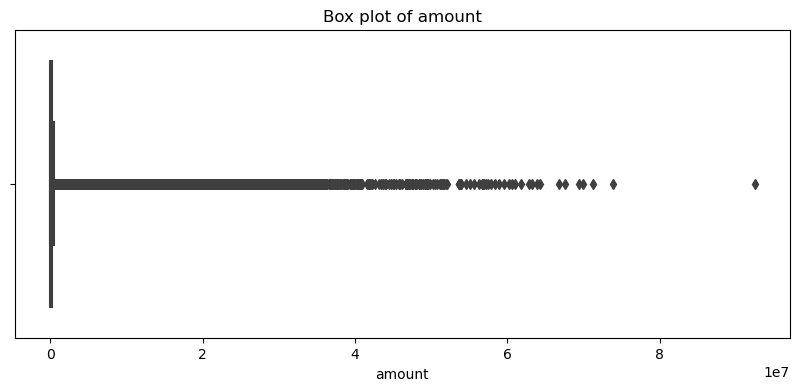

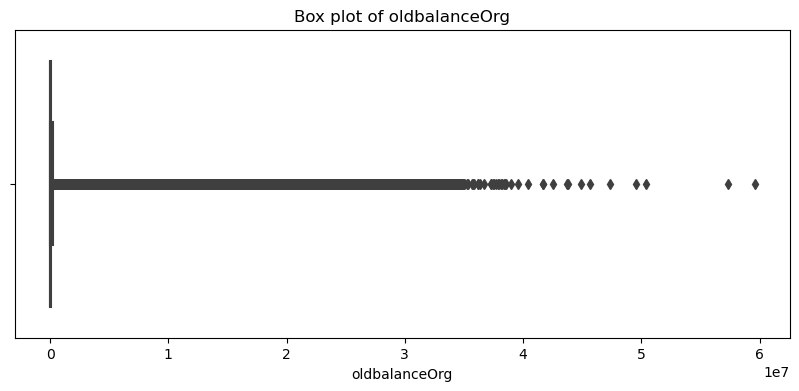

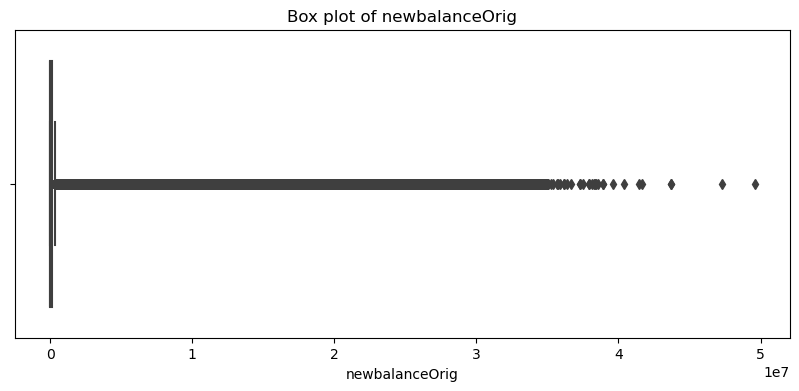

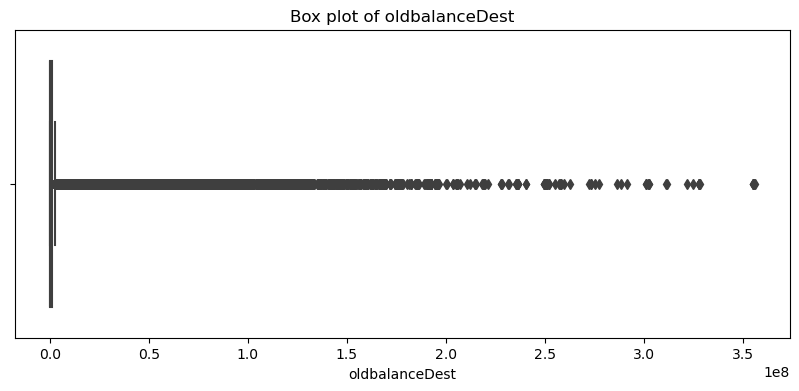

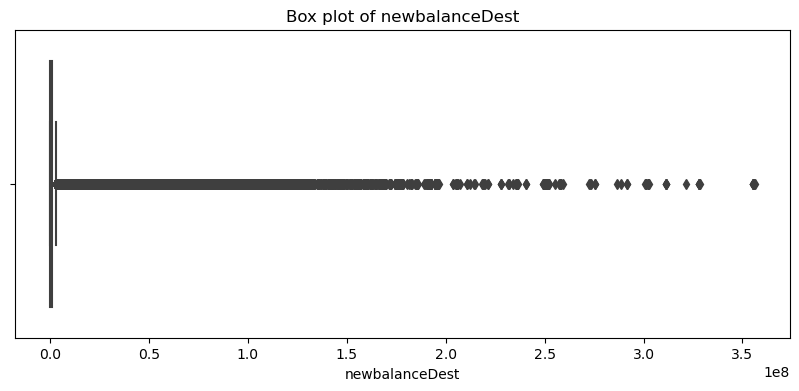

In [6]:
for column in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Box plot of {column}')
    plt.show()

    Q1 = df[column].quantile(0.25)  ##25th percentile of the data
    Q3 = df[column].quantile(0.75)  ##75th percentile
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound,
                            np.where(df[column] < lower_bound, lower_bound, df[column]))


In [36]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
numerical_df = df[num_features].drop(['step','isFraud','isFlaggedFraud'],axis =1)

In [37]:
numerical_df

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,9839.64000,170136.0000,160296.36,0.000000e+00,0.000
1,1864.28000,21249.0000,19384.72,0.000000e+00,0.000
2,181.00000,181.0000,0.00,0.000000e+00,0.000
3,181.00000,181.0000,0.00,2.118200e+04,0.000
4,11668.14000,41554.0000,29885.86,0.000000e+00,0.000
...,...,...,...,...,...
6362615,339682.13000,268287.9375,0.00,0.000000e+00,339682.130
6362616,501719.33875,268287.9375,0.00,0.000000e+00,0.000
6362617,501719.33875,268287.9375,0.00,6.848884e+04,2779773.125
6362618,501719.33875,268287.9375,0.00,0.000000e+00,0.000


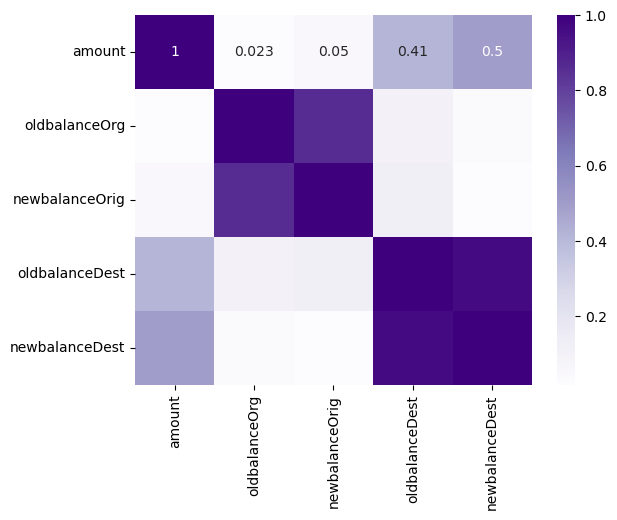

In [38]:
corr_matrix = numerical_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='Purples')
plt.show()